# Standard Bank Tech Impact Challenge: Animal classification

The objective of this challenge is to create a machine learning model to accurately predict the likelihood that an image contains a zebra, as opposed to an elephant. While this may be an easy task for humans, elephants, and zebras, your computer will find it a bit more difficult.

The total dataset contains 13,999 images of zebras and elephants, sampled from the Snapshot Serengeti collection of more than 6 million animals.

Your task is to predict whether a given image contains a zebra or elephant. For each unique image ID in the test set you should estimate the likelihood that the image contains a zebra or elephant, with an estimated probability value between 0 and 1. A value of 1 represents a zebra and 0 represents an elephant. These images do not contain both simultaneously. It is therefore only a binary classification task.

### Dataset:
You are given 13,999 photos each with a unique identifier. The data is given in jpeg format. Each photo has already been resized to 330x330 pixels.

### Importing the libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import matplotlib.image as mpimg
import seaborn as sns

# Keras 
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img 
from keras.preprocessing import image

from tqdm import tqdm
import tensorflow as tf

## Part 1 - Data Augmentation & Preprocessing

### Loading the Data

In [2]:
path_to_folder_train = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training"
image_paths = os.listdir(path_to_folder_train)
train = [path_to_folder_train+"/"+i for i in image_paths]

path_to_folder_validate = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Validation"
image_paths = os.listdir(path_to_folder_validate)
validate= [path_to_folder_validate+"/"+i for i in image_paths]

path_to_folder_test = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Testing"
image_paths = os.listdir(path_to_folder_test)
test = [path_to_folder_test+"/"+i for i in image_paths]

In [3]:
#train_imgs = train_zebras[:400] + train_eliphants[:400]
train_imgs = train
random.shuffle(train_imgs)
del train
gc.collect()

44

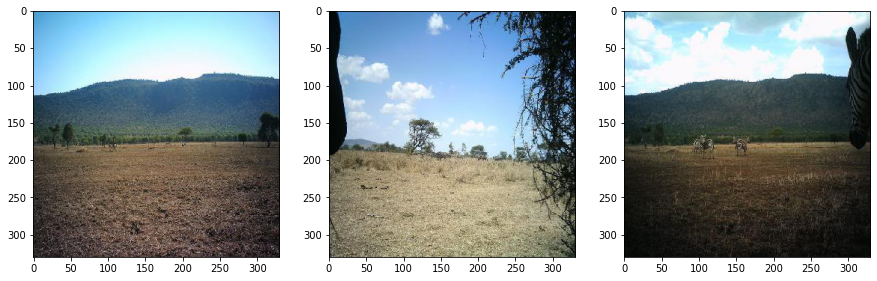

In [4]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,ima in enumerate(train_imgs[0:3]):
    img = mpimg.imread(ima)
    imgplot = ax[i].imshow(img)
plt.show() 

In [5]:
#We can change this later, if we want
nrows = 64
ncolums = 64 
channels = 3

In [6]:
def get_image_x(image):
    return cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR) , (nrows, ncolums) , interpolation = cv2.INTER_CUBIC)
    
def read_and_process_image(list_of_images):
    x = []
    y = []
    for image in tqdm(list_of_images):
        try:
            x.append(get_image_x(image))
        except:
            print("An image caused a probelem",image)
            continue
        if "elephant" in image:
            y.append(0)
        else:
            y.append(1)   
    return x,y

In [7]:
X, y = read_and_process_image(train_imgs)
del train_imgs
gc.collect()

 90%|█████████ | 9011/10000 [00:39<00:03, 328.05it/s]

An image caused a probelem /Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training/IMG10288_zebra.jpeg


100%|██████████| 10000/10000 [00:42<00:00, 237.00it/s]


42

/Users/tomashegewisch/lunch_lab_project_final/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


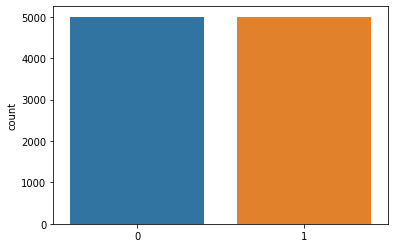

In [8]:
X = np.array(X)
y = np.array(y)
sns.countplot(y)
plt.show()

In [9]:
print("The shape of x:", X.shape)
print("The shape of y:", y.shape)
# X -> batch size, height, width and channels

The shape of x: (9999, 64, 64, 3)
The shape of y: (9999,)


#"The model takes as input an array of ( height, width,channels)"

In [10]:
X_train = X 
y_train = y

X_val, y_val = read_and_process_image(validate)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test, y_test = read_and_process_image(test)
X_test = np.array(X_test)
y_test = np.array(y_test)

del validate
del test

100%|██████████| 2000/2000 [00:06<00:00, 310.29it/s]


In [11]:
print("The shape of X_train:",X_train.shape)
print("The Shape of X_val:", X_val.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of y_val:", y_val.shape)

print("The shape of X_test:",X_test.shape)
print("The shape of y_test:", y_test.shape)

The shape of X_train: (9999, 64, 64, 3)
The Shape of X_val: (2000, 64, 64, 3)
The shape of y_train: (9999,)
The shape of y_val: (2000,)
The shape of X_test: (2000, 64, 64, 3)
The shape of y_test: (2000,)


In [12]:
#clear
del X
del y
gc.collect()

2427

In [13]:
ntrain = len(X_train)
nval = len(X_val)

In [14]:
batch_size = 32 

### Example of Data Augmentation

Data augmentation is an essential way to fight overfitting for computer vision models. It is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset. 

This is helpful in instances where the training set size is deemed not large enough, or when the model requires variations of the images that it learns from, so it can improve the ability and robustness of the fit models to generalize what they have learned to new images. These new images could be supplied in more warped variations from the images the model learns off, and this variation in images supplied to the model to train on builds this robustness.

Training deep learning neural network models on more data can also result in more skillful models. In order to make the most of our training examples, we will "augment" them via a number of random transformations, so that at training time, our model will never see the exact same picture twice.

Here I have created an instance of the ImageDataGenerator module to illustrate the capabilities of the augmentationt transformations on the image dataset.

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Above you will find a few of the options available for augmenting the images in your dataset with ImageDataGenerator.

- rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
- width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
- shear_range is for randomly applying shearing transformations.
- zoom_range is for randomly zooming inside pictures.
- horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

In [ ]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
import os

# Now I shall import a single image and showcase the results of various augmentation techniques

base_dir = 'C:/Users/User/Documents/Varisty/Masters/Techpreneurship Program/Assignments/Final Project/dataset/'
direc = os.path.join(base_dir, 'Train')
train_el_dir = os.path.join(direc, 'elephants')
elephants = os.listdir(train_el_dir)

img_path = os.path.join(train_el_dir, elephants[2])

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images. It loops indefinitely, so we need to include a `break` the loop.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

The images supplied showcase the manner in which the augmentation occurs, by few of the techniques given in the datagen instance above for ImageDataGenerator. This shows how the images change upon augmentation and how the model comes to learn off these. Now we will preprocess and augment the training, validation and test sets, properly. 

### *Data reshaped*
using centering,
normalization or
standardization.
- *More than one*
type of data
preprocessing
technique considered

### Preprocessing the Training set

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# train_datagen.fit(X_train)

# training_set = train_datagen.flow_from_directory(
#         directory=direc,
#         target_size=(64,64),
#         batch_size=32,
#         class_mode='binary')
training_set =  train_datagen.flow(X_train, y_train, batch_size = batch_size)

The target size of 64x64 pixels was used as 32x32 pixels had a much lower test accuracy, and 128x128 pixels takes much longer to run - for only a small increase in accuracy. The batch size also denotes the size of groups of training (or later, validation and test sets, too) data that are scaled at a time. Two sizes were evaluated: 32 and 64, of which a batch size of 32 images has a higher test accuracy. This value is used.

The ImageDataGenerator class can be used to rescale pixel values from the range of 0-255 to the range 0-1 (by dividing by 255) which is preferred for neural network models. This would act to normalize the data for the model. Without any further preprcessing, by means of standardization or normalization, the Test Accuracy was 63.75%.

The data, however, can be centred/standardised in a featurewise or samplewise manner (i.e., overall for the training set, or per image), which may be beneficial when training neural networks, especially with standardization as the dataset sums to zero and the inputs are small values in the rough range of about -3.0 to 3.0 (e.g. 99.7 of the values will fall within three standard deviations of the mean).

Therefore, to assist in identifying the best performing model preprocessing technique, normalization and standardization techniques were both tested and evaluated. Below is a summary of results obtained using an 'adam' optimizer and 'binary crossentropy' loss function, with the accuracy metric included. As it stands, a *featurewise standardization* is the best performing preprocessing. 

For rescaling & featurewise standardisation: *test accuracy of 78.4%.*
For rescaling & samplewise standardisation: *test accuracy of 72.90%.*
For rescaling & featurewise normalization: *test accuracy of 71.85%.*
Only rescaling: *test accuracy of 63.8%.*

### Preprocessing the Validation set

In [16]:
valid_datagen = ImageDataGenerator(
    rescale=1./255)
# valid_direc = os.path.join(base_dir, 'Valid')

# valid_datagen.fit(X_train)

# validation_set = valid_datagen.flow_from_directory(
#     directory=valid_direc,
#     target_size=(64,64),
#     batch_size=32,
#     class_mode = 'binary')
validation_set = valid_datagen.flow(X_val, y_val, batch_size= batch_size)

### Preprocessing the Test set

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#         directory=test_direc,
#         target_size=(64, 64),
#         batch_size=32,
#         class_mode='binary',
#         seed=42)
test_set = test_datagen.flow(X_test, y_test, batch_size= batch_size)

## Part 2 - Choosing Model & Building It

### Choosing the model:
The model chosen was a structured neural network, or a convolutional neural network (CNN). CNNs are fully connected, forward, neural networks. CNNs are effective in reducing the number of parameters/dimension by filtering, pooling and flattening the data, without losing on the quality of models. Images have high dimensionality (as each pixel is considered as a feature) which suits the above described abilities of CNNs. Also, CNNs were developed keeping images into consideration and are trained to identify the edges of objects in any image.

All the layers of a CNN have multiple convolutional filters which work and scan the complete feature matrix (of the input data) and carry out the dimensionality reduction. This enables CNN to be a very apt and fit network for image classifications and processing.

## More than one
type of model (or
di􀃠erent
con􀃕gurations of
the same type
i.e. di􀃠erent
structured NNs)
chosen. + motivations!!!!

## First Model: 2-Layered CNN

In [18]:
# cnn = tf.keras.models.Sequential()
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
# cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# cnn.add(tf.keras.layers.Flatten())
# cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
# cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
# cnn.summary()

## Second Model: 4-Layered CNN

### Initialising the CNN

In [ ]:
#cnn = models.Sequential()

### Step 1 - Convolution

In [ ]:
#cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(64, 64, 3)))

### Step 2 - Pooling

In [ ]:
#cnn.add(layers.MaxPooling2D ((2, 2)))

### Adding another three convolutional layers

In [ ]:
#cnn.add(layers.Conv2D(64, (3,3), activation = "relu"))
#cnn.add(layers.MaxPooling2D ((2,2)))
#cnn.add(layers.Conv2D(128, (3,3), activation = "relu"))
#cnn.add(layers.MaxPooling2D((2,2)))
#cnn.add(layers.Conv2D(256, (3,3), activation = "relu"))
#cnn.add(layers.MaxPooling2D((2,2)))

### Step 3 - Flattening

In [ ]:
#cnn.add(layers.Flatten())

### Step 4 - Dropout Layer

In [ ]:
#cnn.add(layers.Dropout(0.5)) # Dropot of regularisation

### Step 5 - Fully Connected Layer

In [ ]:
#cnn.add(layers.Dense(512, activation = "relu"))

### Step 6 - Output Layer

In [ ]:
#cnn.add(layers.Dense(1, activation = 'sigmoid'))
#cnn.summary()

In [19]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(64, 64, 3)))
cnn.add(layers.MaxPooling2D ((2, 2)))
cnn.add(layers.Conv2D(64, (3,3), activation = "relu"))
cnn.add(layers.MaxPooling2D ((2,2)))
cnn.add(layers.Conv2D(128, (3,3), activation = "relu"))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Conv2D(256, (3,3), activation = "relu"))
cnn.add(layers.MaxPooling2D((2,2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.5)) # Dropot of regularisation
cnn.add(layers.Dense(512, activation = "relu"))
cnn.add(layers.Dense(1, activation = 'sigmoid'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

## Part 3 - Model Training

### Compiling the Model

In [20]:
optimmizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
cnn.compile(optimizer=optimmizer, loss='binary_crossentropy', metrics=['accuracy'])
# alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8
# cnn.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-14), metrics = ['accuracy'])

### EarlyStopping is used as a means of tuning the hyperparameter, number of epochs.

In [ ]:
from keras import callbacks 
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy",  
                                        mode ="max", patience = 8,  
                                        restore_best_weights = True) 

### Training the Model on the Training set and evaluating it on the Validation set.

In [21]:
history = cnn.fit(training_set, 
        validation_data = validation_set, 
        epochs = 65)

Epoch 1/65
313/313 [==============================] - 121s 382ms/step - loss: 0.5354 - accuracy: 0.7122 - val_loss: 0.3186 - val_accuracy: 0.8625
Epoch 2/65
313/313 [==============================] - 110s 353ms/step - loss: 0.3305 - accuracy: 0.8556 - val_loss: 0.3018 - val_accuracy: 0.8755
Epoch 3/65
313/313 [==============================] - 105s 336ms/step - loss: 0.2762 - accuracy: 0.8853 - val_loss: 0.2574 - val_accuracy: 0.9125
Epoch 4/65
313/313 [==============================] - 104s 331ms/step - loss: 0.2380 - accuracy: 0.9054 - val_loss: 0.2517 - val_accuracy: 0.8895
Epoch 5/65
313/313 [==============================] - 105s 335ms/step - loss: 0.2094 - accuracy: 0.9160 - val_loss: 0.1791 - val_accuracy: 0.9310
Epoch 6/65
313/313 [==============================] - 102s 327ms/step - loss: 0.1800 - accuracy: 0.9291 - val_loss: 0.1485 - val_accuracy: 0.9415
Epoch 7/65
313/313 [==============================] - 105s 337ms/step - loss: 0.1901 - accuracy: 0.9234 - val_loss: 0.1714 -

## Part 4 - Model Tuning

- Verbose was put on 2 so the details of the Model.fit() method could be shown, along with the results.


- The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. This parameter needs to be optimised. This was done by using a callback method (EarlyStopping) to halt the process once the validation loss reaches a minimum - and checks it by continuing 5 more epochs afterwards - which allows us to view the optimum number of epochs to use for the model so as to prevent overfitting.


- optimizer in the compile() method was evaluated for the best method. Adam is noted to be one of the best optimizer methods, and RMSProp is also dually noted across various articles. For the sake of this project, two optimizers were evaluated: 'adam' and 'rmsprop'. Adam did in fact work out to be better, and is supported by literature to be an appropriate method for problems with very noisy/or sparse gradients; also, instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance). Adam is a popular algorithm in the field of deep learning because it achieves good results fast and that is why it was chosen as the optimizer function.


- for the loss function, the 'binary crossentropy' function is used as it noted widely to be intended for use with binary classification tasks, where the target values are in the set {0, 1}. To be specific, cross entropy is equivalent to fitting the model with maximum likelihood estimation - which minimises dissimilarity between the training data empirical distribution and the model's induced distribution. These estimators have good asymptomatic properties and are consistent, as well as being statistically significant. This cross-entropy function gives well-calibrated probabilities.

## Part 5 - Model Evaluation/Performance

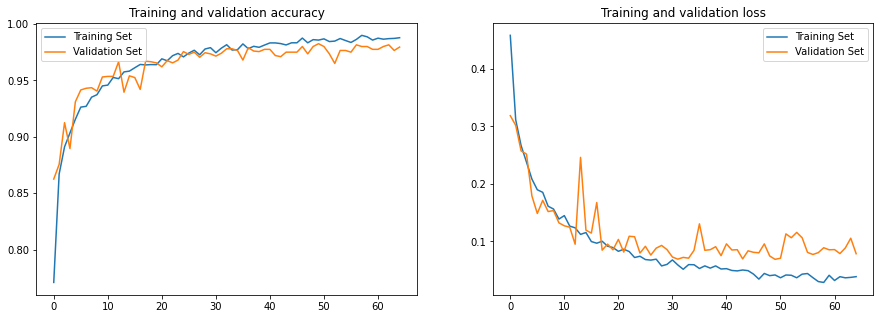

<Figure size 432x288 with 0 Axes>

In [22]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1,2,figsize=(15,5))

# Plot training and validation accuracy per epoch
ax[0].plot(epochs, acc, label='Training Set')
ax[0].plot(epochs, val_acc, label='Validation Set')
ax[0].legend()
ax[0].title.set_text('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
ax[1].plot(epochs, loss, label='Training Set')
ax[1].plot(epochs, val_loss, label='Validation Set')
ax[1].legend()
ax[1].title.set_text('Training and validation loss')
plt.show()

### Discussion on Results


## Part 6: Test Accuracy

In [23]:
p, acc = cnn.evaluate(test_set, steps=len(test_set), verbose=0, batch_size=batch_size)
print('Test Accuracy: %.3f' % (acc * 100))

Test Accuracy: 98.200


### Discussion on Results:

The test set shows an almost perfect results for a prediction of binary image classification.

The first thing to note is that we’re not overfitting as the train and validation accuracy are pretty close and following each other.

We can also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size will likely give us a higher accuracy.

## Part 7 - Visualising the Results

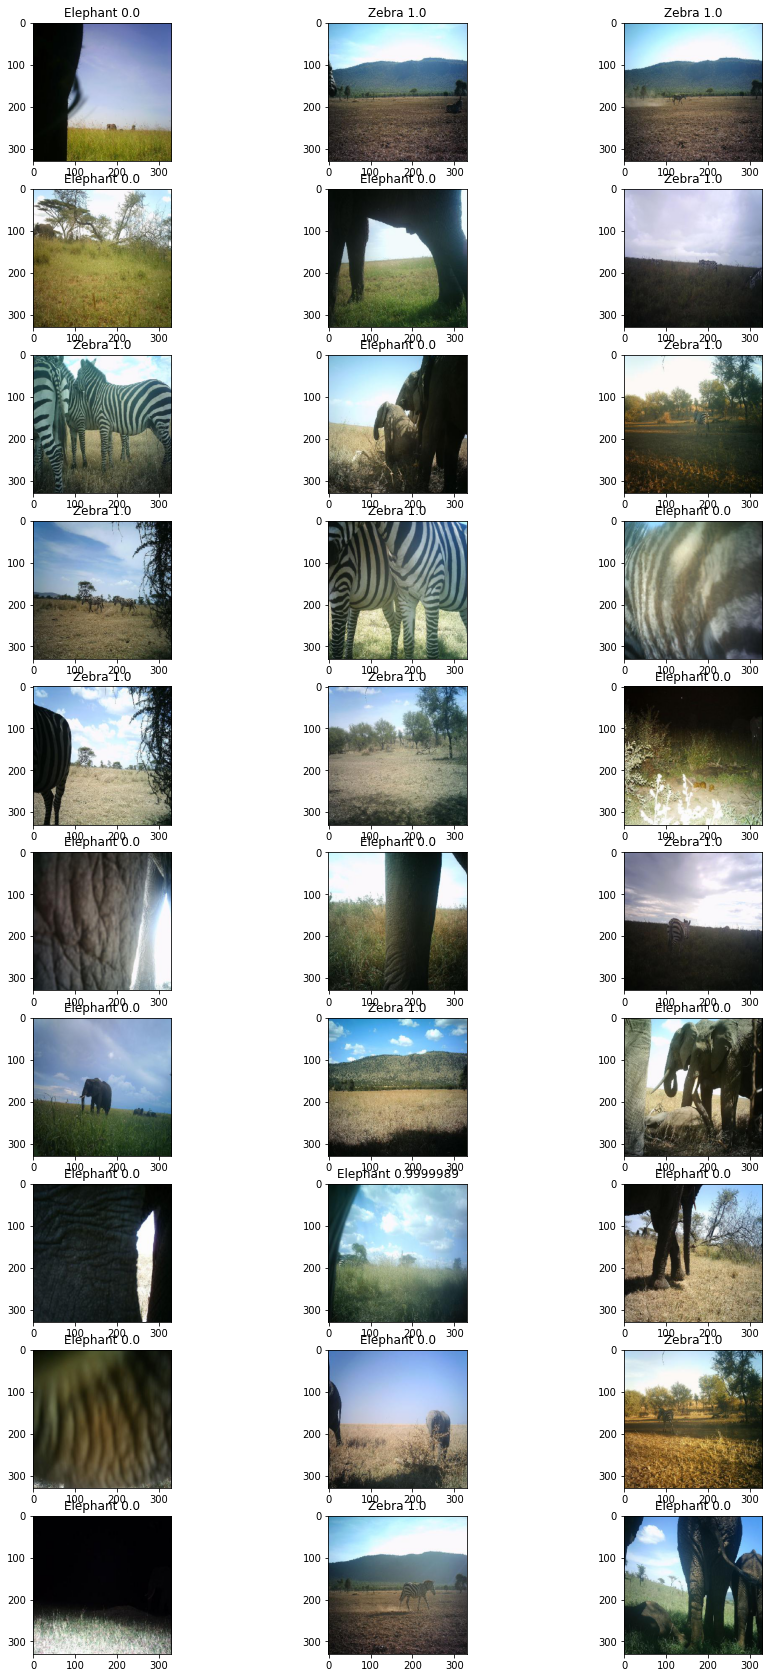

In [24]:
fig, ax = plt.subplots(10,3,figsize=(15,30))
ax = ax.flatten()
for i in range(0,30):
    path_to_folder = '/Users/tomashegewisch/Downloads/data_set/test/'
    path_to_folder = '/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Testing/'
    image_paths = os.listdir(path_to_folder)
    file = np.random.choice(image_paths)
    path_to_test_image = path_to_folder + file
    
    #New worn
    x = np.array([get_image_x(path_to_test_image)])
    result = cnn.predict(x)

    if result[0][0] == 1:
        prediction = 'Zebra'
    else:
        prediction = 'Elephant'

    img = mpimg.imread(path_to_test_image)
#     imgplot = 
    ax[i].imshow(img)
    ax[i].title.set_text(prediction+" "+str(result[0][0]))
plt.show()